---

<h1 align="center">Covid 19 - Risk Prediction</h1>
<h3 align="center">Alessandro Sebastiano Catinello</h3>
<h5 align="center"> Marzo 2023</h5>

L'obiettivo di questo progetto è: mostrare l'implementazione di un **classificatore binario** che, dati i sintomi attuali, lo stato e la storia clinica di un paziente che ha contratto il Covid-19, sia capace di predire se il paziente è a rischio di sviluppare una forma grave della malattia o meno; andremo inoltre a sviluppare un **modello di sopravvivenza** che, data la stessa informazione, sia capace di predire la probabilità di sopravvivenza del paziente.

Inizialmente eseguiremo una prima fase di **data cleaning** per testare la qualità dei dati e, qualora fosse necessario, modificarli per renderli più adatti allo studio. 
Successivamente, dopo aver effettuato una breve **analisi esplorativa** sui dati, costruiremo le **curve di sopravvivenza** e infine si testeranno diversi **classificatori**. 

A tale fine utilizzeremo:
- K-Nearest Neighbors (KNN)
- Support Vector Machine (SVM)
- Naive Bayes (Normal e Multinomial)
- Random Forest
- Logistic Regression

Per ogni algoritmo testeremo vari iperparametri e ne valuteremo le prestazioni, effettueremo inoltre un **confronto** tra i diversi classificatori.


---
<h3>Indice</h3>


1. [Configurazione dell'ambiente](#sec1)
2. [Presentazione Dataset e conversione](#sec2)
3. [Data Cleaning](#sec3)
4. [Analisi Dati - EDA](#sec4)
5. [Curve di sopravvivenza](#sec5)
6. [Classificatori](#sec6)
7. [Conclusione](#sec7)

---

<a id="sec1"></a>
## 1. Configurazione dell'ambiente


In [2]:
import json
import numpy as np
import pandas as pd
import weightedstats as ws
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [3]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import pairwise_logrank_test

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB

In [5]:
import cudf as cupd
from cuml.neighbors import KNeighborsClassifier
from cuml.svm import SVC as cuSVC, LinearSVC as cuLinearSVC
from cuml import RandomForestClassifier as cuRandomForestClassifier
from cuml.model_selection import train_test_split as cuTrainTestSplit

--- 
<a id="sec2"></a>

## 2. Presentazione Dataset e conversione

Il dataset utilizzato è fornito dal governo Messicano ([link](https://www.gob.mx/salud/documentos/datos-abiertos-152127)) e contiene informazioni di pazienti anonimi, comprese le condizioni pregresse, riguardanti l'infezione da SARS-CoV-2 o, più comunemente, Covid-19. Il Dataset contiene circa 4 milioni di pazienti univoci ed è diviso in 24 colonne. Nelle colonne **booleane** troveremo 1 = "SI", 2 = "NO" e 97, 98, 99 = "NON DISPONIBILE":

1. **Patient ID**: ID univoco identificativo del paziente
   
2. **Sex**: Sesso del paziente (1 = Femmina, 2 = Maschio).
3. **Age**: Età del paziente.
4. **Patient type**: Tipo di cura che il paziente ha ricevuto. 1 = "CASA", 2 = "OSPEDALIZZATO".
5. **Admission date**: Data di ammissione del paziente.
6. **Symptoms date**: Data in cui il paziente ha iniziato a manifestare i sintomi.
7. **Death date**: In caso di decesso, ne indica la data; altrimenti troveremo "9999-99-99".
8. **Pneumonia**: Indica se il paziente fosse già affetto da polmonite.
9.  **Pregnancy**: Indica se il paziente fosse in gravidanza.
10. **Diabetes**: Indica se il paziente fosse affetto da diabete.
11. **Copd**: Indica se il paziente fosse affetto da malattie polmonari ostruttive croniche.
12. **Ashtma**: Indica se il paziente fosse affetto da asma.
13. **Inmsupr**: Indica se il paziente fosse immunosoppresso.
14. **Hypertension**: Indica se il paziente fosse affetto da ipertensione.
15. **Cardiovascular**: Indice se il paziente fosse affetto da malattie relative al cuore o ai vasi sanguigni. (Sistema Cardiovascolare)
16. **Renal Chronic**: Indica se il paziente fosse affetto da malattie renali croniche.
17. **Other Desease**: Indica se il paziente fosse affetto da altre malattie.
18. **Obesity**: Indica se il paziente fosse affetto da obesità.
19. **Tobacco**: Indica se il paziente fosse fumatore.
20. **USMER**: Indica se il paziente è stato trattato da un'unità medica nazionale
21. **Origin Country**: Indica il paese di origine del paziente.
22. **Medical Unit**: Indica il tipo di unità medica del Sistema Medico Nazionale che ha curato il paziente.
23. **Intubed**: Indica se il paziente è stato intubato. 
24. **ICU**: Indica se il paziente è stato ricoverato in terapia intensiva.

Data la mole del Dataset, il formato "csv" nativo non è ottimale per le prestazioni e il salvataggio dei dati. Per questo motivo, convertiremo il dataset in un formato più performante, in particolare in un formato "parquet". Questo formato è ottimale per i dataset di grandi dimensioni e permette di salvare i dati in un formato compresso, che permette di ridurre il tempo di caricamento e di salvataggio dei dati. 

A tale fine utilizzeremo la libreria Python "[pyarrow](https://arrow.apache.org/docs/python/index.html)".

In [2]:
# df = pd.read_csv("covidOriginal.csv")
# df.to_parquet("covidOriginal.parquet")

---
<a id="seg3"></a>

## 3. Data Cleaning

### 3.1. Caricamento del Dataset

In [21]:
covid = pd.read_parquet("covidOriginal.parquet")
covid.head()

,PATIENT_ID,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,ADMISSION_DATE,SYMPTOMS_DATE,DEATH_DATE,INTUBED,PNEUMONIA,...,ASTHMA,INMUSUPR,HYPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,ORIGIN_COUNTRY,ICU
0,z4d6fe,1,6,1,1,2020-12-06,2020-11-30,9999-99-99,97,2,...,2,2,2,2,2,2,2,2,97,97
1,z3bf80,2,12,2,1,2020-07-28,2020-07-20,9999-99-99,97,2,...,2,2,2,2,2,2,2,2,97,97
2,z54912,1,12,1,1,2020-06-12,2020-06-10,9999-99-99,97,2,...,2,2,2,2,2,2,2,2,97,97
3,z552ac,1,12,1,1,2020-06-02,2020-05-30,9999-99-99,97,2,...,2,2,2,2,2,2,2,2,97,97
4,z59345,1,12,2,1,2020-07-01,2020-06-30,9999-99-99,97,2,...,2,2,2,2,2,2,2,2,97,97


### 3.2. Conversioni ovvie

Osservando i dati notiamo che nella colonna **PREGNANT** i valori per gli utenti maschi sono tutti 97, 98, 99. Ovviamente però non è possibile che un uomo sia in gravidanza. Per questo motivo, sostituiamo questi valori con 2, che indica "NO".

In [22]:
covid.loc[covid["SEX"] == 2, "PREGNANT"] = 2

### 3.3. Eliminazione righe con valori mancanti e conversione in valori booleani

Andremo ora a selezionare le colonne booleane, in queste andremo a eliminare le righe con valori mancanti (97, 98, 99) e infine convertiremo i valori rimanenti in valori booleani. Creeremo inoltre una colonna aggiuntive "**DIED**" per salvare il valore booleano di "Death Date" se diverso da "9999-99-99".

Otterremo infine quindi nella colonna "**SEX**" i valori 1 = "Femmina", 0 = "Maschio" e nelle altre colonne booleane i valori 1 = "SI", 0 = "NO".

Convertiamo inoltre le colonne contenenti delle date in formato "Datetime" .

In [23]:
columns = [elem for elem in covid.columns if elem not in ["PATIENT_ID", "USMER", "SYMPTOMS_DATE",
            "MEDICAL_UNIT", "ADMISSION_DATE", "PATIENT_TYPE",
            "DEATH_DATE", "AGE", "ORIGIN_COUNTRY"]]

for col in columns:
    covid = covid.loc[(covid[col] == 1) | (covid[col] == 2)]
    covid[col] = covid[col] == 1

covid["DIED"] = covid.DEATH_DATE != "9999-99-99"
for col in ("DEATH_DATE", "ADMISSION_DATE", "SYMPTOMS_DATE"):
    covid.loc[covid[col] == "9999-99-99", col] = pd.NaT
    covid[col] = pd.to_datetime(covid[col])

### 3.5 Colonna "DAYS

Creiamo una nuova colonna "**DAYS**" che conterrà il numero di giorni trascorsi tra la data di inizio sintomi e la data di decesso. Se il paziente non è deceduto, il valore sarà 0. Utilizzeremo questa colonna per lo studio delle curve di sopravvivenza, ma soprattutto sarà indispensabile per riconoscere gli outliner.

In particolare utilizzeremo il metodo degli **scarti interquantili** per riconoscere ed escludere gli outliner. Tale metodo consiste nel trovare il **range interquantile** ovvero il range di elementi che si trovano tra il 75° (Q3) e il 25° (Q1) percentile della distribuzione (solitamente Gaussiana) dei dati, si elimineranno poi tutti gli elementi che sono inferiori a (Q1 - 1.5 * IQR) o superiori a (Q3 + 1.5 * IQR), dove IQR = Q3 - Q1.

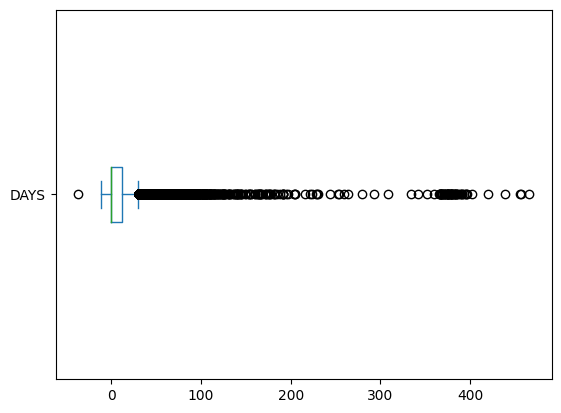

In [24]:
covid["DAYS"] = (covid.DEATH_DATE - covid.SYMPTOMS_DATE).dt.days
covid.DAYS = covid.DAYS.fillna(0)

covid.DAYS.plot(kind="box", vert=False);

Come notiamo dal **box plot** che segue, la distribuzione dei dati è molto asimmetrica, con una lunga coda a destra. Questo significa che la maggior parte dei pazienti è deceduta in tempi brevi, ma che esistono anche pazienti che sono deceduti dopo molti giorni. Per questo motivo, non possiamo semplicemente eliminare i pazienti che sono deceduti dopo un certo numero di giorni, ma dobbiamo utilizzare il metodo degli scarti interquantili. Notiamo anche la presenza di valori negativi.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 596278 entries, 15 to 4075326
Data columns (total 26 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   PATIENT_ID      596278 non-null  object        
 1   USMER           596278 non-null  int64         
 2   MEDICAL_UNIT    596278 non-null  int64         
 3   SEX             596278 non-null  bool          
 4   PATIENT_TYPE    596278 non-null  int64         
 5   ADMISSION_DATE  596278 non-null  datetime64[ns]
 6   SYMPTOMS_DATE   596278 non-null  datetime64[ns]
 7   DEATH_DATE      270815 non-null  datetime64[ns]
 8   INTUBED         596278 non-null  bool          
 9   PNEUMONIA       596278 non-null  bool          
 10  AGE             596278 non-null  int64         
 11  PREGNANT        596278 non-null  bool          
 12  DIABETES        596278 non-null  bool          
 13  COPD            596278 non-null  bool          
 14  ASTHMA          596278 non-null  b

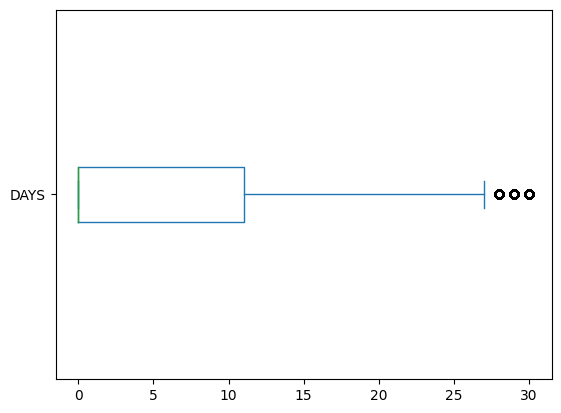

In [25]:
covid = covid[covid.DAYS >= 0]

q25, q75 = np.percentile(covid.DAYS, [25, 75])
iqr = q75 - q25

covid = covid[(covid.DAYS <= q75 + 1.5 * iqr) & (covid.DAYS >= q25 - 1.5 * iqr)]
covid.DAYS.plot(kind="box", vert=False);
covid.info()

Dopo l'eliminazione delgli outliner notiamo che, tra i pazienti deceduti, la maggior parte è deceduta in tempi brevi, ma che esistono anche pazienti che sono deceduti dopo più giorni, ma sempre in tempi ragionevoli per la malattia in studio.

### 3.4. Colonna "AT_RISK"

Data la classificazione da eseguire, creeremo una colonna "**AT_RISK**" che indica se il paziente, una volta contratto il covid, è a rischio di imbattersi in complicanze. Per fare ciò utilizzeremo le colonne "**DIED**", "**INTUBED**" e "**ICU**" in quanto sono le complicanze peggiori che possono verificarsi, e ne effettueremo l'OR logico.

Salviamo infine il dataset pulito in un file parquet.

In [26]:
covid["AT_RISK"] = covid.DIED | covid.ICU | covid.INTUBED
# covid.to_parquet("covidClean.parquet")

covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 596278 entries, 15 to 4075326
Data columns (total 27 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   PATIENT_ID      596278 non-null  object        
 1   USMER           596278 non-null  int64         
 2   MEDICAL_UNIT    596278 non-null  int64         
 3   SEX             596278 non-null  bool          
 4   PATIENT_TYPE    596278 non-null  int64         
 5   ADMISSION_DATE  596278 non-null  datetime64[ns]
 6   SYMPTOMS_DATE   596278 non-null  datetime64[ns]
 7   DEATH_DATE      270815 non-null  datetime64[ns]
 8   INTUBED         596278 non-null  bool          
 9   PNEUMONIA       596278 non-null  bool          
 10  AGE             596278 non-null  int64         
 11  PREGNANT        596278 non-null  bool          
 12  DIABETES        596278 non-null  bool          
 13  COPD            596278 non-null  bool          
 14  ASTHMA          596278 non-null  b

---

<a id="sec4"></a>
## 4. Analisi Dati

Andremo ora a studiare i dati, per capire come sono distribuiti e quali sono le caratteristiche dei pazienti in studio. 

In [9]:
covidEDA = covid.copy()
covidEDA.head()

,PATIENT_ID,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,ADMISSION_DATE,SYMPTOMS_DATE,DEATH_DATE,INTUBED,PNEUMONIA,...,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,ORIGIN_COUNTRY,ICU,DIED,DAYS,AT_RISK
15,z22bc2,2,13,False,2,2020-06-26,2020-06-25,NaT,False,True,...,False,False,False,False,False,97,True,False,0.0,True
17,z4494e,2,12,True,2,2020-11-09,2020-11-02,NaT,False,False,...,False,False,False,False,False,97,False,False,0.0,False
19,z388cd,1,12,False,2,2020-07-01,2020-06-26,NaT,False,True,...,False,False,False,False,False,97,False,False,0.0,False
21,z166d5,1,12,True,2,2020-04-17,2020-04-14,NaT,False,True,...,False,False,False,False,False,97,False,False,0.0,False
25,z49a69,1,12,True,2,2020-07-20,2020-07-17,2020-07-21,True,True,...,False,False,True,False,False,97,True,True,4.0,True



### 4.1 Distribuzione dei pazienti per sesso

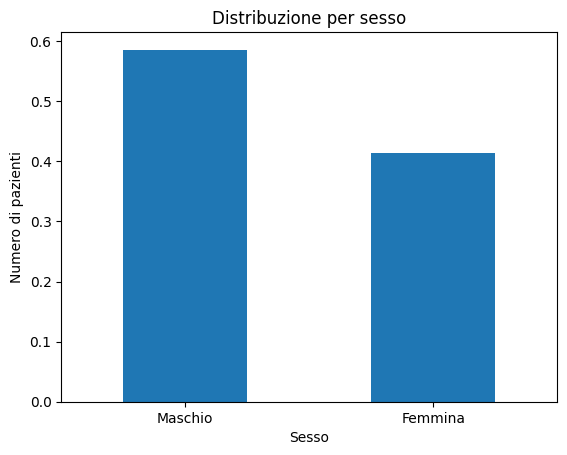

In [10]:
covidEDA.SEX.value_counts(normalize=True).plot(kind="bar", xlabel="Sesso",
                                               ylabel="Numero di pazienti",
                                               title="Distribuzione per sesso");
plt.xticks([0, 1], ["Maschio", "Femmina"], rotation=0);


### 4.2 Distribuzione dei pazienti per età

Da tale grafico possiamo notare che i pazienti esaminati sono tutti adulti, e che la maggior parte dei pazienti è compresa tra i 40 e i 75 anni.

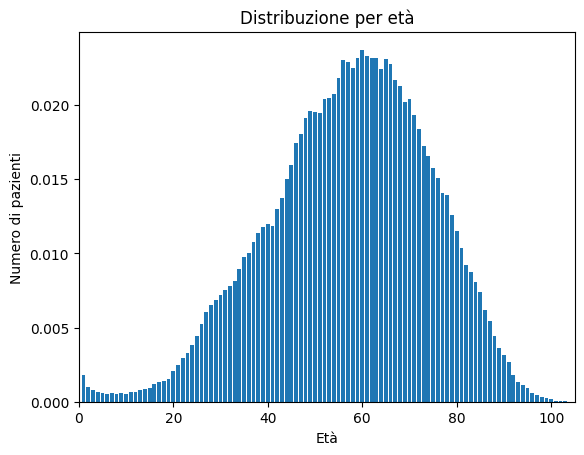

In [11]:
age = covidEDA.AGE[covidEDA.AGE != 0].value_counts(normalize=True)
plt.bar(age.index, age.values)
plt.xlabel("Età")
plt.ylabel("Numero di pazienti")
plt.title("Distribuzione per età")
plt.xlim(0, 105)
plt.show();


### 4.3 Distribuzione dei pazienti per giorni trascorsi tra la data di inizio sintomi e la data di decesso

Come visto in precedenza la maggior parte dei pazienti è deceduta tra i 5 e 10 giorni.

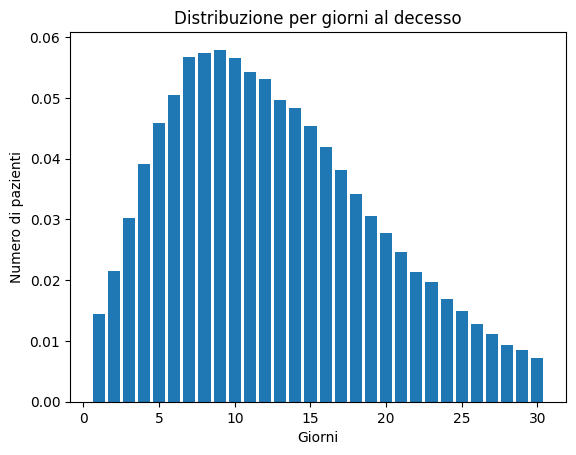

In [12]:
days = covidEDA.DAYS[covidEDA.DAYS != 0].astype(int).value_counts(normalize=True)
plt.bar(days.index, days.values)
plt.title("Distribuzione per giorni al decesso")
plt.ylabel("Numero di pazienti")
plt.xlabel("Giorni")
plt.show();

--- 
<a id="sec5"></a>
## 5. Curve di Sopravvivenza

Efettueremo ora uno studio delle curve di sopravvivenza, per capire se esistono delle caratteristiche che permettono di prevedere la sopravvivenza dei pazienti e per identificare le feature più significative nello studio. Per fare ciò utilizzeremo la libreria Python "[lifelines](https://lifelines.readthedocs.io/en/latest/)". 

In [13]:
covidSurv = covid.copy()
toRemove = ["PATIENT_ID", "USMER", "SYMPTOMS_DATE",
            "MEDICAL_UNIT", "ADMISSION_DATE", "PATIENT_TYPE",
            "DEATH_DATE", "ORIGIN_COUNTRY", "AT_RISK"]
covidSurv = covidSurv.drop(columns = toRemove)
covidSurv.head()

,SEX,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMUSUPR,HYPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,ICU,DIED,DAYS
15,False,False,True,60,False,True,False,False,False,False,False,False,False,False,False,True,False,0.0
17,True,False,False,49,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0
19,False,False,True,12,False,True,False,False,False,False,False,False,False,False,False,False,False,0.0
21,True,False,True,32,False,True,False,False,False,True,False,False,False,False,False,False,False,0.0
25,True,True,True,66,False,True,False,False,False,True,False,False,True,False,False,True,True,4.0


Utilizzeremo la funzione "**KaplanMeierFitter**" per calcolare la curva di sopravvivenza. Tale funzione esegue lo stimatore Kaplan-Meier, in particolare, utilizzeremo la colonna **DAYS** per modellare gli intervalli temporali e la colonna **DIED** per indicare la censura dei dati: se il paziente è deceduto, il valore sarà 1, altrimenti 0 e quindi sarà censurato (right-censoring).

Analizzeremo grafici che mettono in relazione la presenza o no della feature in analisi. Per fare ciò necessitiamo di trasformare la colonna **AGE** in booleana, in particolare, calcoleremo la **mediana pesata** e trasformeremo la colonna in relazione a tale valore. Per calcolare la mediana utilizzeremo la libreria **weightedstats** e utilizzeremo la frequenza di ogni età come peso.

In [14]:
medianAge = ws.numpy_weighted_median(covidSurv.AGE, covidSurv.AGE.value_counts())
covidSurv.AGE = covidSurv.AGE > medianAge

print("Età media: " + str(medianAge))
covidSurv.head()

Età media: 49


,SEX,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMUSUPR,HYPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,ICU,DIED,DAYS
15,False,False,True,True,False,True,False,False,False,False,False,False,False,False,False,True,False,0.0
17,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0
19,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,0.0
21,True,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,0.0
25,True,True,True,True,False,True,False,False,False,True,False,False,True,False,False,True,True,4.0


### 5.1 Distribuzione giorni di sopravvivenza

Come visto anche in precendeza, dal grafico sottostante possiamo notare in generale che i primi 15-20 giorni sono indispensabili per la sopravvivenza del paziente che riscontra sintomatologie gravi.

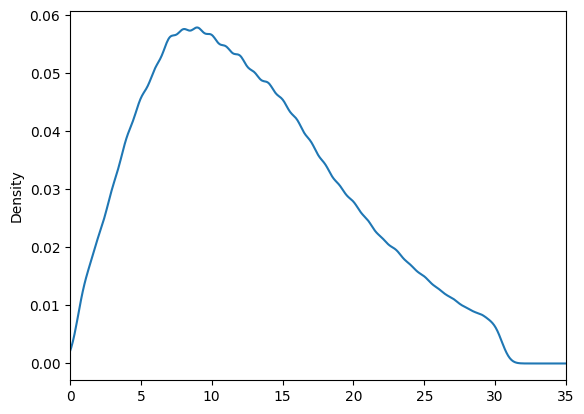

In [15]:
covidSurv.DAYS[covidSurv.DAYS != 0].plot(kind="kde", xlim=(0, 35));

### 5.2 Significatività delle feature (P-value)

Calcoleremo ora la significatività delle feature, per capire quali sono le più significative nello studio. Per fare ciò utilizzeremo la funzione "**logrank_test**" della libreria "lifelines". Tale funzione esegue il test di Logrank, che è un test statistico per confrontare due curve di sopravvivenza. Tale test non è parametrico, quindi non fa alcuna ipotesi sulla distribuzione dei dati.

In particolare attenzioneremo il valore **p-value** che indica la probabilità che le due curve di sopravvivenza siano uguali. Se tale valore è inferiore ad un certo valore soglia (ad esempio 0.05), allora le due curve sono statisticamente diverse e quindi una delle due feature è significativa.

In [16]:
def getPValues(df):
    res = {}
    columns = [x for x in df.columns if x != "DAYS" and x != "DIED"]
    for col in columns:
        res[col] = pairwise_logrank_test(df["DAYS"], df[col], df["DIED"]).p_value[0]
    return res

In [17]:
pValues = getPValues(covidSurv)
pValues = sorted(pValues.items(), key=lambda x: x[1])

print("P-values: \n")
for key, value in pValues:
    print(key + ": " + str(value))

P-values: 

INTUBED: 0.0
RENAL_CHRONIC: 0.0
ICU: 0.0
DIABETES: 1.969999737420521e-162
PNEUMONIA: 4.060346433131771e-68
HYPERTENSION: 9.972417579384005e-49
COPD: 2.3395414222754644e-35
CARDIOVASCULAR: 1.0500527472287335e-33
SEX: 7.7632508582167e-28
AGE: 7.286640194096744e-13
INMUSUPR: 1.972787771778073e-12
TOBACCO: 5.693326807703877e-12
OBESITY: 8.384186893401736e-12
PREGNANT: 2.464904365667908e-10
ASTHMA: 0.00025083142520305476
OTHER_DISEASE: 0.012777992994615775


Come possiamo notare, tra le feature più significative troviamo **INTUBED** e **ICU** in quanto ci si aspetta che un paziente sottoposto a terapia intensiva o all'utilizzo di respiratore abbia probabilità di sopravvivenza superiori. Caso interessante è la forte significatività della feature **RENAL_CHRONIC** che indica, evidentemente, una correlazione tra le malattie croniche renali e le probabilità di sopravvivenza da Covid-19.

Andiamo ora a visualizzare graficamente tutte le curve di sopravvivenza.

In [28]:
def printGraph(df, colname, legend = ["NO", "YES"], fontsize=9):
    for elem in set(df[colname]):
        indexis = df[df[colname] == elem]
        
        kmf = KaplanMeierFitter()
        kmf.fit(indexis["DAYS"], indexis["DIED"])
        ax = kmf.plot(label = legend[elem])
        
        pValue = pairwise_logrank_test(df["DAYS"], df[colname], df["DIED"]).p_value[0]
        plt.text(0.1, 0.1, "p-value: " + str(pValue), fontsize=fontsize)
        plt.title(colname)
        plt.grid(True)
        
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

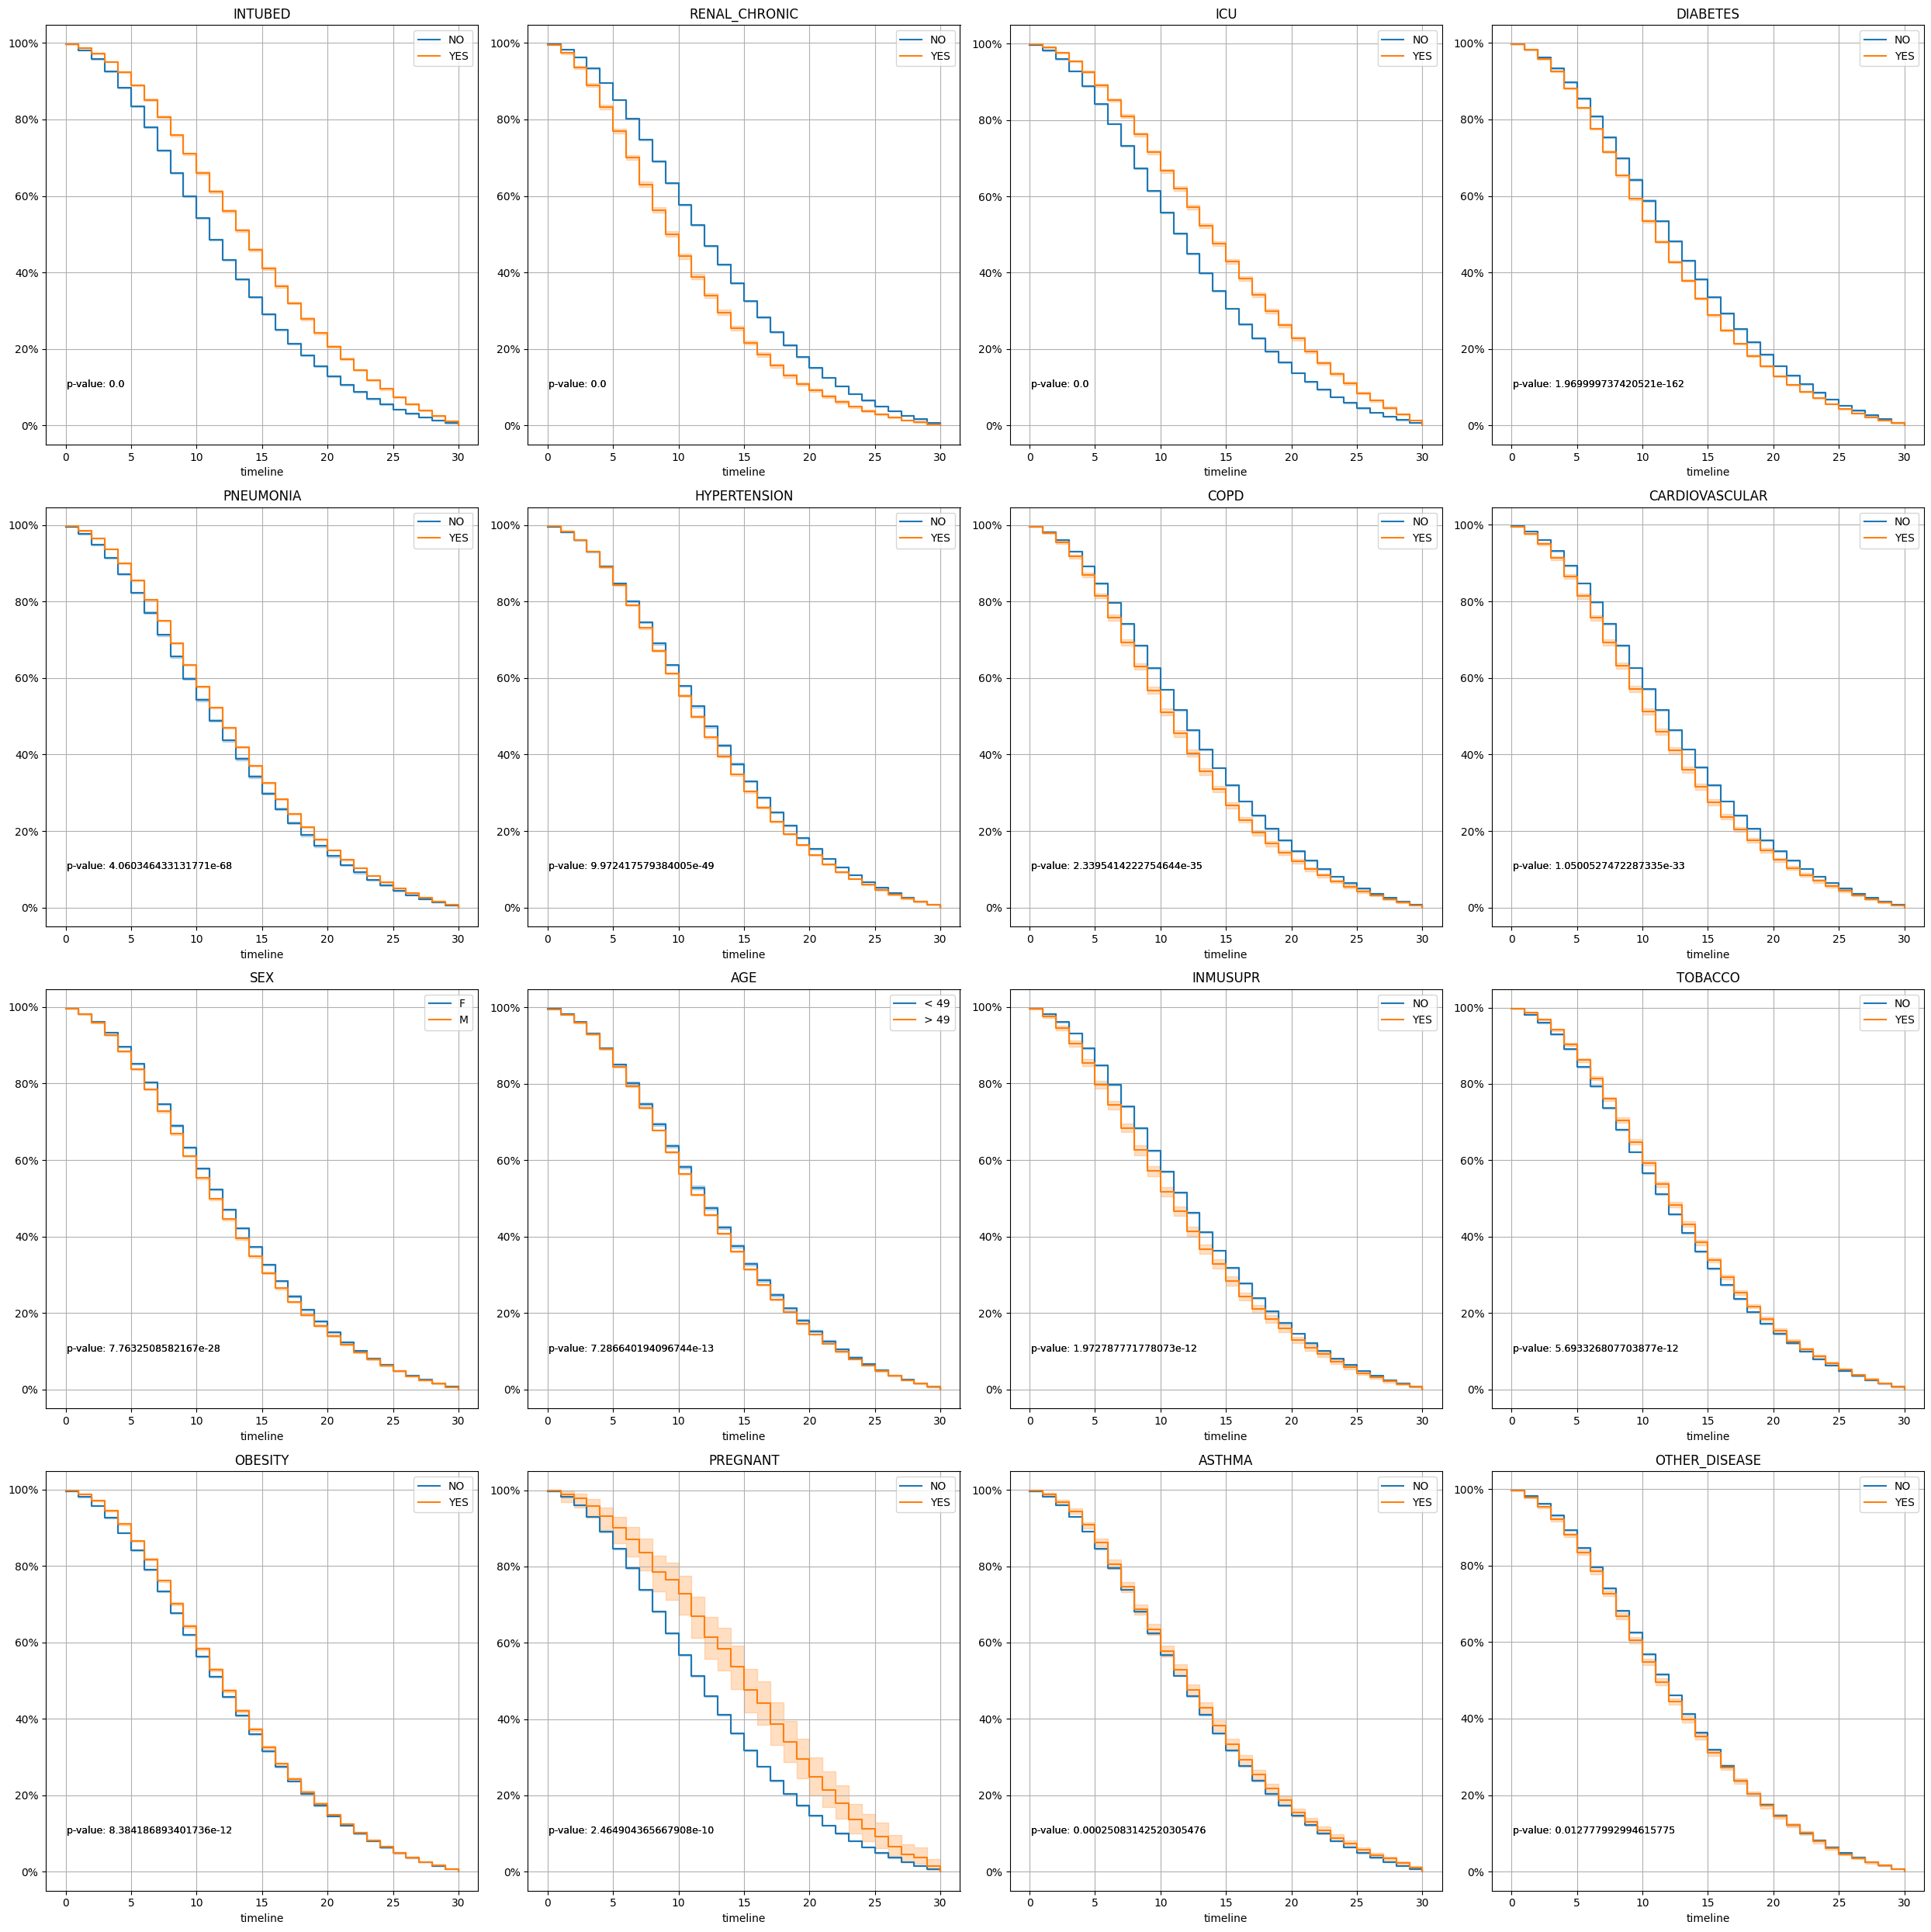

In [30]:
plt.figure(figsize=(25, 25))
for i in range(4):
    for j in range(4):
        plt.subplot(4, 4, i * 4 + j + 1)
        col = pValues[i * 4 + j][0]
        legend = ["NO", "YES"]
        if col == "AGE":
            legend = ["< " + str(medianAge), "> " + str(medianAge)]
        if col == "SEX":
            legend = ["F", "M"]
        printGraph(covidSurv, col, legend)
plt.tight_layout()
plt.show()

Possiamo notare che, come detto in precedenza, le curve delle feature più significative sono visivamente differenti; caso particolare invece è la curva di **PREGNANT** in quanto abbiamo un p-Value poco significativo rispetto alle altre feature ma la curva sembra essere **visivamente indicativa**. Si pone l'attenzione però al bordo arancione che contorna la curva "YES": tale contorno rappresenta l'**intervallo di confidenza**, più è largo il contorno, minore è la confidenza dello stimatore. Solitamente (come anche in questo caso) il contorno aumenta di larghezza con l'avanzare negli intervalli di tempo, nel nostro caso in particolare però è più logico attribuire tale comportamento al forte sbilanciamento tra le due classi: la classe "PREGNANT-NO" è molto più numerosa della classe "PREGNANT-YES".

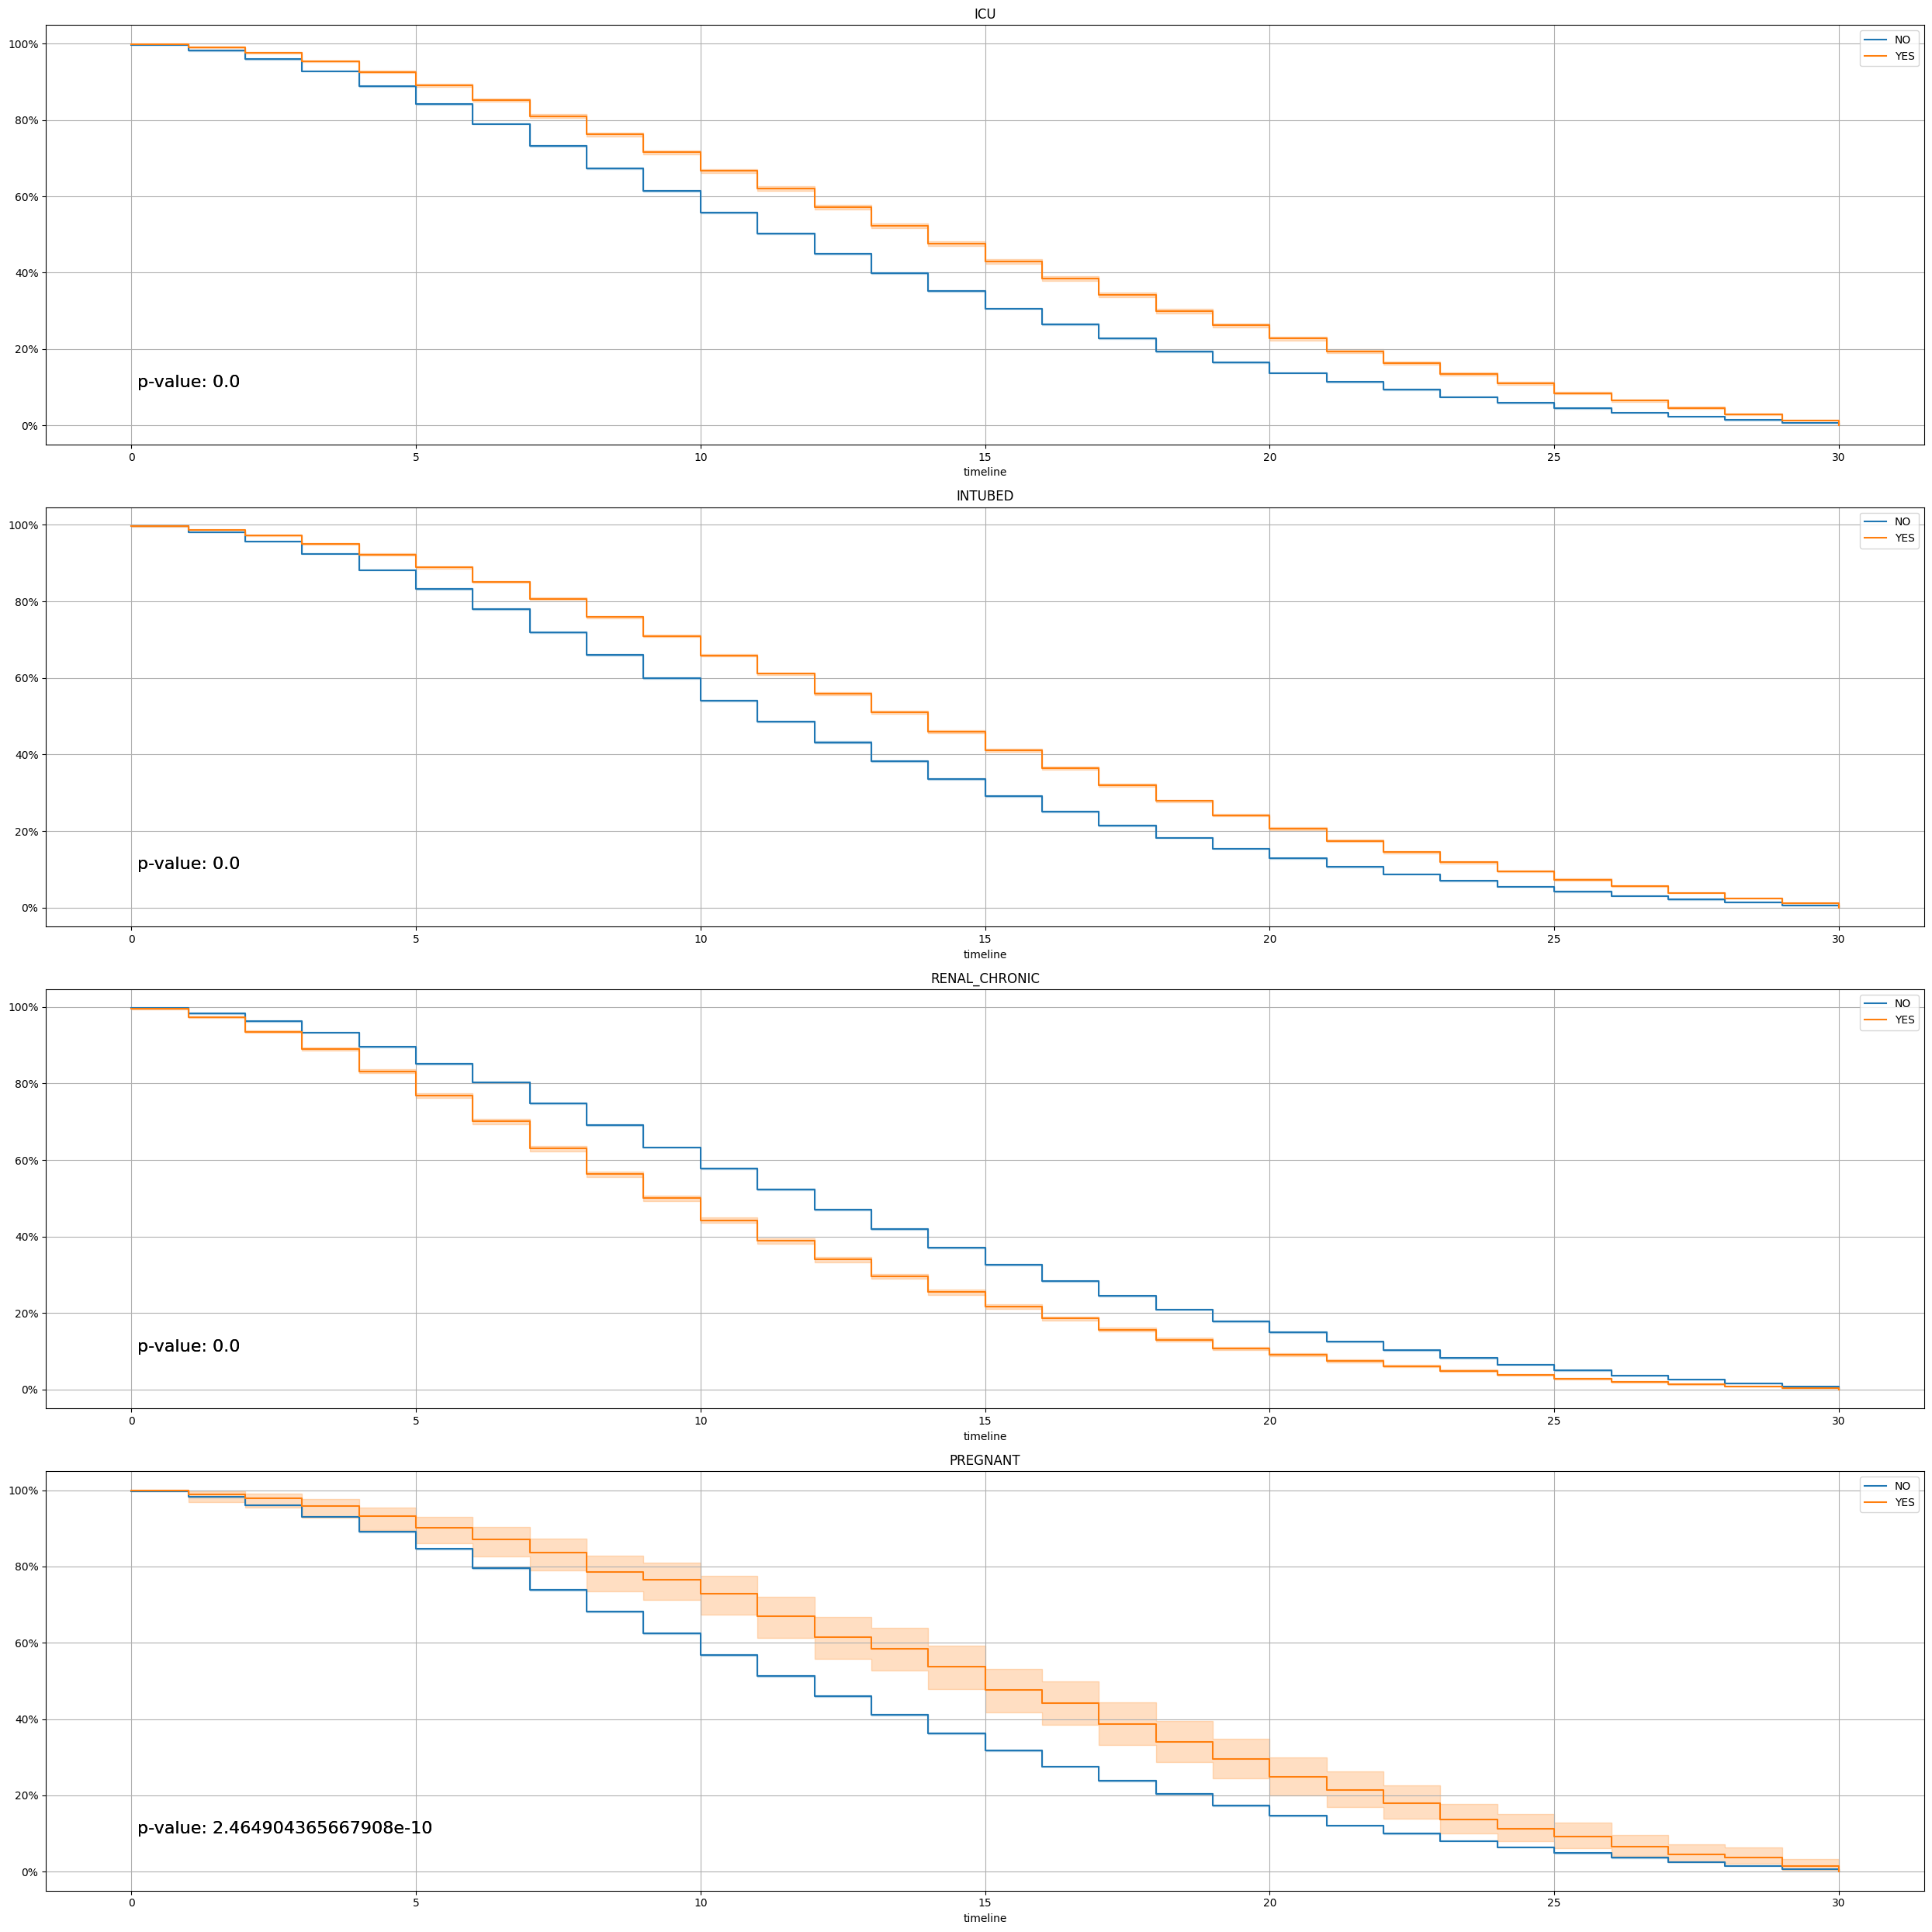

In [29]:
features = ["ICU", "INTUBED", "RENAL_CHRONIC", "PREGNANT"]
plt.figure(figsize=(25, 25))
for i in range(4):
    plt.subplot(4, 1, i+1)
    printGraph(covidSurv, features[i], fontsize=16)
plt.tight_layout()
plt.show()

---
<a id="sec6"></a>
## 6. Classificazione

Andremo ora a creare un modello di classificazione che, dato un paziente, possa prevedere se il paziente è a rischio di complicanze o meno. Per fare ciò utilizzeremo la libreria Python "[scikit-learn](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning)" e la libreria "[rapids](https://rapids.ai)" che offre un'implementazione parallelizzata su GPU cuda della libreria "scikit-learn".

### 6.1 Metriche

Definiamo intanto le funzioni che ci serviranno per valutare i modelli di classificazione. Calcoleremo in principio la matrice di confusione (nel nostro caso binaria) e da essa andremo poi a calcolare le varie metriche: accuracy, precision, recall e F1-Score. Tra queste metriche ci porremo l'obiettivo di massimizzare la recall in quanto, essendo fondamentalmente una classificazione medic, preferiamo classificare erroneamente una persona come "a rischio" piuttosto che non riconoscere un potenziale rischio (nel peggiore dei casi, il paziente agirà con cautela anche quando non necessario).

In [7]:
def getConfusionMatrix(labels: np.ndarray, predictions: np.ndarray):
    confusion = dict()
    confusion["TP"] = np.sum(labels & predictions)
    confusion["TN"] = np.sum(~labels & ~predictions)
    confusion["FP"] = np.sum(~labels & predictions)
    confusion["FN"] = np.sum(labels & ~predictions)
    return confusion

def getMetrics(confusion):
    metrics = dict()
    metrics["accuracy"] = (confusion["TP"] + confusion["TN"]) / (confusion["TP"] + confusion["TN"] + confusion["FP"] + confusion["FN"])
    metrics["precision"] = confusion["TP"] / (confusion["TP"] + confusion["FP"])
    metrics["recall"] = confusion["TP"] / (confusion["TP"] + confusion["FN"])
    metrics["f1"] = 2 * (metrics["precision"] * metrics["recall"]) / (metrics["precision"] + metrics["recall"])
    return metrics

def printMetrics(confusion):
    print("Accuracy: \t", confusion["accuracy"])
    print("Precision: \t", confusion["precision"])
    print("Recall: \t", confusion["recall"])
    print("F1: \t\t", confusion["f1"])
    
def printAll(confusionTrain, confusionTest):
    print("Accuracy: \t", confusionTrain["accuracy"], "\tAccuracy: \t", confusionTest["accuracy"])
    print("Precision: \t", confusionTrain["precision"], "\tPrecision: \t", confusionTest["precision"])
    print("Recall: \t", confusionTrain["recall"], "\tRecall: \t", confusionTest["recall"])
    print("F1: \t\t", confusionTrain["f1"], "\tF1: \t\t", confusionTest["f1"])

In [8]:
def convertToNumpy(df):
    return df.to_pandas().to_numpy().astype("bool")

In [18]:
bestRes = dict()

### 6.2 Caricamento dati
#### 6.2.1 Caricamento dati su CPU

In [22]:
covidClass = covid.copy()

toRemove = ["PATIENT_ID", "USMER", "SYMPTOMS_DATE",
            "MEDICAL_UNIT", "ADMISSION_DATE", "PATIENT_TYPE",
            "DEATH_DATE", "ORIGIN_COUNTRY", "DAYS"]
covidClass = covidClass.drop(columns = toRemove)
covidClass = covidClass.drop(columns = ["DIED", "INTUBED", "ICU"])

In [23]:
labels = covidClass.AT_RISK
covidClass = covidClass.drop(columns= ["AT_RISK"])

trainingX, testX, trainingY, testY = train_test_split(covidClass, labels, test_size=0.25)

#### 6.2.2 Caricamento dati su GPU

In [7]:
cuCovid = cupd.read_parquet('covidClean.parquet')

toRemove = ["PATIENT_ID", "USMER", "SYMPTOMS_DATE",
            "MEDICAL_UNIT", "ADMISSION_DATE", "PATIENT_TYPE",
            "DEATH_DATE", "ORIGIN_COUNTRY", "DAYS"]
cuCovid = cuCovid.drop(columns = toRemove)
cuCovid = cuCovid.drop(columns= ["DIED", "INTUBED", "ICU"])
cuCovid = cuCovid.astype('float32')

In [8]:
labels = cuCovid.AT_RISK
covidX = cuCovid.drop(columns = ["AT_RISK"])

cuTrainingX, cuTestX, cuTrainingY, cuTestY = cuTrainTestSplit(covidX, labels, test_size=0.25)

cuTestY = convertToNumpy(cuTestY)
cuTrainY = convertToNumpy(cuTrainingY)

### 6.3 Random Forest

Utilizzeremo ora un modello di classificazione basato su alberi di decisione, in particolare, utilizzeremo la classe **RandomForestClassifier** della libreria "rapids-cuml".
Tale modello è un ensemble di alberi di decisione, ogni albero viene costruito in modo indipendente e in parallelo, quindi il modello è molto veloce e scalabile. Inoltre, essendo un ensemble, il modello è più robusto e meno soggetto al sovrapprendimento. Il risultato finale è dato dalla media delle predizioni di tutti gli alberi.

Ci concentreremo su modelli RandomForest costruiti utilizzando **gini** e **entropia** come misure di goodness per la costruzione dei singoli alberi decisionali. Probabilmente, data la natura sparsa del dataset, le prestazioni tra le due euristiche non varieranno di molto ma varierà invece l'altezza degli alberi data la differente metodologia di costruzione. 

Cerchiamo quindi l'altezza massima che massimizza la recall con 100 stimatori.

In [10]:
metric = "recall"
depths = range(3, 21, 2)
heuristics = ["entropy", "gini"]
results = {
    "entropy": dict(),
    "gini": dict()
}

for heuristic in heuristics:
    for depth in depths:
        rf = cuRandomForestClassifier(n_estimators=100, max_depth=depth, split_criterion=heuristic)
        rf.fit(cuTrainingX, cuTrainingY)

        predictionsTest = rf.predict(cuTestX)
        predictionsTest = convertToNumpy(predictionsTest)
        metricsTest = getMetrics(getConfusionMatrix(cuTestY, predictionsTest))
        results[heuristic][depth] = metricsTest[metric]
        if(depth > 3 and results[heuristic][depth - 2] > metricsTest[metric]):
            break

In [11]:
for (heuristic, values) in results.items():
    print("Heuristic:", heuristic)
    for (depth, m) in values.items():
        print("Depth:", depth, "\t", metric, ":", m)
        
bestDepthEntropy = max(results["entropy"], key=results["entropy"].get)
bestDepthGini = max(results["gini"], key=results["gini"].get)

print()
print("Best Gini Depth: ", bestDepthGini)
print("Best Entropy Depth: ", bestDepthEntropy)

Heuristic: entropy
Depth: 3 	 recall : 0.6438101649276338
Depth: 5 	 recall : 0.6537327499158533
Depth: 7 	 recall : 0.6610434197239986
Depth: 9 	 recall : 0.67524739145069
Depth: 11 	 recall : 0.6832446987546281
Depth: 13 	 recall : 0.6842948502187816
Depth: 15 	 recall : 0.6850622685964322
Depth: 17 	 recall : 0.6849680242342645
Heuristic: gini
Depth: 3 	 recall : 0.6444025580612588
Depth: 5 	 recall : 0.6542443621676203
Depth: 7 	 recall : 0.6592797038034331
Depth: 9 	 recall : 0.673187478963312
Depth: 11 	 recall : 0.6791114102995625
Depth: 13 	 recall : 0.6834735779198923
Depth: 15 	 recall : 0.6802019522046449

Best Gini Depth:  13
Best Entropy Depth:  15


Andiamo ora a eseguire il modello con i parametri trovati e salviamone i risultati.

In [12]:
res = dict()
for heuristic in heuristics:
    rf = cuRandomForestClassifier(n_estimators=100, 
                                max_depth=max(results[heuristic], key=results[heuristic].get), 
                                split_criterion=heuristic)
    rf.fit(cuTrainingX, cuTrainingY)

    predictionsTrain = rf.predict(cuTrainingX)
    predictionsTest = rf.predict(cuTestX)

    predictionsTrain = convertToNumpy(predictionsTrain)
    predictionsTest = convertToNumpy(predictionsTest)

    metricsTest = getMetrics(getConfusionMatrix(cuTestY, predictionsTest))
    metricsTrain = getMetrics(getConfusionMatrix(cuTrainY, predictionsTrain))
    
    res[heuristic] = metricsTest

    print("\nRF '" + heuristic + "' (GPU) on Training Set: \tRF '" + heuristic + "' (GPU) on Test Set:")
    printAll(metricsTrain, metricsTest)


RF 'entropy' (GPU) on Training Set: 	RF 'entropy' (GPU) on Test Set:
Accuracy: 	 0.6483210311062613 	Accuracy: 	 0.638939014818641
Precision: 	 0.6344197099366303 	Precision: 	 0.625759401825024
Recall: 	 0.696395596909231 	Recall: 	 0.6850622685964322
F1: 		 0.6639645491295392 	F1: 		 0.6540693750843569

RF 'gini' (GPU) on Training Set: 	RF 'gini' (GPU) on Test Set:
Accuracy: 	 0.647596537636765 	Accuracy: 	 0.6386975159154485
Precision: 	 0.6341394503226652 	Precision: 	 0.6258475725522105
Recall: 	 0.694109790422919 	Recall: 	 0.6834735779198923
F1: 		 0.6627707924986946 	F1: 		 0.6533924537772944


In [24]:
bestRF = max(res, key=lambda x: res[x]["recall"])
bestRF = res[bestRF]

bestRes["RF"] = bestRF

### 6.4 Naive Bayes

Utilizzeremo ora Naive Bayes. Tale modello è un modello generativo, esegue la classificazione facendo delle assunzioni sulla distribuzione di probabilità delle classi rispetto ai singoli esempi presi in osservazione. In particolare Naive Bayes si basa sull'algoritmo MAP - Maximum a Posteriori che si pone l'obiettivo di calcolare la **probabilità a posteriori** di ogni classe rispetto a ogni esempio e seleziona infine la classe che massimizza tale probabilità. Tale probabilità a posteriori è modellata utilizzando il **Teorema di Bayes**.

Naive Bayes si distingue da MAP in quanto assume che le feature siano indipendenti tra loro, così facendo il calcolo della likehood diventa il prodotto di probabilità condizionate monodimensionali, semplificando di molto la complessità computazionale e spaziale dell'algoritmo. Tale ipotesi è detta "naive" in quanto non è sempre vera, ma in molti casi è una buona approssimazione.

#### 6.4.1 Naive Bayes Gaussiano

Questo approccio è particolarmente adatto per dati numerici, in quanto modella la probabilità di ogni feature come una distribuzione Gaussiana monodimensionale. In particolare, per ogni classe, viene calcolata la media e la deviazione standard delle feature e viene utilizzata la formula della distribuzione Gaussiana per calcolare la probabilità di ogni feature rispetto ad ogni esempio.

In [28]:
nb = GaussianNB()
nb.fit(trainingX, trainingY)

predictionsTrain = nb.predict(trainingX)
predictionsTest = nb.predict(testX)

metricsTest = getMetrics(getConfusionMatrix(testY, predictionsTest))
metricsTraing = getMetrics(getConfusionMatrix(trainingY, predictionsTrain))

print("\nNB Gaussian on Training Set: \t\tNB Gaussian on Test Set:")
printAll(metricsTraing, metricsTest)

bestRes["Gaussian NB"] = metricsTest


NB Gaussian on Training Set: 		NB Gaussian on Test Set:
Accuracy: 	 0.6270147224557701 	Accuracy: 	 0.6255517542094318
Precision: 	 0.5995075287865368 	Precision: 	 0.5988834538494258
Recall: 	 0.7588822015122839 	Recall: 	 0.7568028810621229
F1: 		 0.669845454689405 	F1: 		 0.6686454109950907


#### 6.4.2 Naive Bayes Bernoulli

Questo approccio invece utilizza la distribuzione di probabilità Bernoulli per modellare la probabilità di ogni feature rispetto ad ogni esempio. Tale distribuzione è particolarmente adatta per dati binari.

Nel nostro caso abbiamo quindi la necessità di convertire la feature **AGE** in booleana, a tale fine calcoleremo la mediana pesata esattamente come abbiamo fatto in precedenza per le curve di sopravvivenza. Avremo così tutte le feature booleane.

In [10]:
trainXCategorial = trainingX.copy()
trainXCategorial.AGE = trainingX.AGE >= ws.numpy_weighted_median(trainingX.AGE.to_numpy(), trainingX.AGE.value_counts())

nb = BernoulliNB()
nb.fit(trainXCategorial, trainingY)

predictionsTrain = nb.predict(trainXCategorial)
predictionTest = nb.predict(testX)

metricsTest = getMetrics(getConfusionMatrix(testY, predictionTest))
metricsTrainig = getMetrics(getConfusionMatrix(trainingY, predictionsTrain))

print("\nNB Bernoulli on Training Set: \t\tNB Bernoulli on Test Set:")
printAll(metricsTrainig, metricsTest)

bestRes["Bernoulli NB"] = metricsTest


NB Bernoulli on Training Set: 		NB Bernoulli on Test Set:
Accuracy: 	 0.6334323178476234 	Accuracy: 	 0.584577715167371
Precision: 	 0.6296733586734201 	Precision: 	 0.5539794909166623
Recall: 	 0.6432651780109407 	Recall: 	 0.8586007986984174
F1: 		 0.6363967049199962 	F1: 		 0.6734445282302505


### 6.5 K-Nearest Neighbors

#### 6.5.1 1-Nearest Neighbor
Nearest Neighbor (1-NN) è un modello di classificazione basato su algoritmi di apprendimento lazy, ciò significa che la fase di training consiste semplicemente nella memorizzazione del training Set: in fase di classificazione, il modello sfrutterà quanto memorizzato per ottenere il risultato desiderato. Tale modello si basa sull'idea che esempi simili verranno mappati vicini tra loro nello spazio, di conseguenza un esempio è simile a quelli che sono vicini a lui. In particolare, il modello calcola la distanza tra un esempio e tutti gli altri esempi e seleziona l'esempio più vicino, la sua classe sarà il risultato della classificazione.

In [9]:
nn = KNeighborsClassifier(n_neighbors=1)
nn.fit(cuTrainingX, cuTrainingY)

predictedTrain = nn.predict(cuTrainingX)
predictedTest = nn.predict(cuTestX)

predictedTrain = convertToNumpy(predictedTrain)
predictedTest = convertToNumpy(predictedTest)

metricsTrain = getMetrics(getConfusionMatrix(cuTrainY, predictedTrain))
metricsTest = getMetrics(getConfusionMatrix(cuTestY, predictedTest))

print("\n1-NN on Training Set: \t\t\t1-NN on Test Set: " )
printAll(metricsTrain, metricsTest)

bestRes["1-NN"] = metricsTest


1-NN on Training Set: 			1-NN on Test Set: 
Accuracy: 	 0.5945139744504248 	Accuracy: 	 0.5662948030777694
Precision: 	 0.5904182134420186 	Precision: 	 0.5625504649285026
Recall: 	 0.6115679885987281 	Recall: 	 0.5817016348406906
F1: 		 0.600807028589417 	F1: 		 0.5719657848044278


#### 6.5.2 K-Nearest Neighbors

Notiamo però che le prestazioni non sono ottimali, questo perchè l'utilizzo di un solo "neighbor" come riferimento non è sufficiente per ottenere un buon risultato, tende infatti a dare troppa importanza agli outliner. Per questo motivo, utilizziamo ora l'algoritmo **K-Nearest Neighbors (KNN)**, che utilizza un numero arbitrario di vicini per la classificazione. Fondamentalmente è la generalizzazione di 1-NN, seleziona però i k-esimi esempi più vicini: la classe che massimizza il numero di vicini sarà il risultato della classificazione. 

"K" è quindi un iperparametro che condiziona le prestazioni del modello. Esistono diversi approcci per la ricerca del valore K, tra questi la ricerca esaustiva crescente non fa altro che eseguire KNN per tutti i valori di un range prestabilito. Tale approccio è però molto dispendioso, per ottimizzare la ricerca quindi si esegue una "pseudo ricerca binaria" nel range di valori di K: per ogni iterazione si esegue KNN con k pari al limite inferiore e superiore del range e con la sua mediana, osservando il risultato ottenuto con la mediana possiamo decidere verso quale limite spostare il range. Questo approccio è molto più veloce e permette di ottenere un buon risultato in tempi brevi.

In [9]:
def findBestK(lower, upper, res: dict, metric="f1"):
    median = (lower + upper) // 2
    if lower == median:
        return lower
    
    results = dict()
    print("K: L -> " + str(lower) + " \tM -> " + str(median) + "\tU -> " + str(upper))
    for k in [lower, median, upper]:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(cuTrainingX, cuTrainingY)
        predicted = knn.predict(cuTestX)
        
        predicted = convertToNumpy(predicted)
        results[k] = getMetrics(getConfusionMatrix(cuTestY, predicted))[metric]
        res[k] = results[k]

    if results[median] > results[lower]:
        return findBestK(median, upper, res, metric)
    else:
        return findBestK(lower, median, res, metric)

In [10]:
metric = "recall"
results = {}
bestK = findBestK(2, 750, results, metric)
print("\nBest K: ", bestK)

K: L -> 2 	M -> 376	U -> 750
K: L -> 376 	M -> 563	U -> 750
K: L -> 376 	M -> 469	U -> 563
K: L -> 376 	M -> 422	U -> 469
K: L -> 376 	M -> 399	U -> 422
K: L -> 376 	M -> 387	U -> 399
K: L -> 376 	M -> 381	U -> 387
K: L -> 376 	M -> 378	U -> 381
K: L -> 376 	M -> 377	U -> 378

Best K:  376


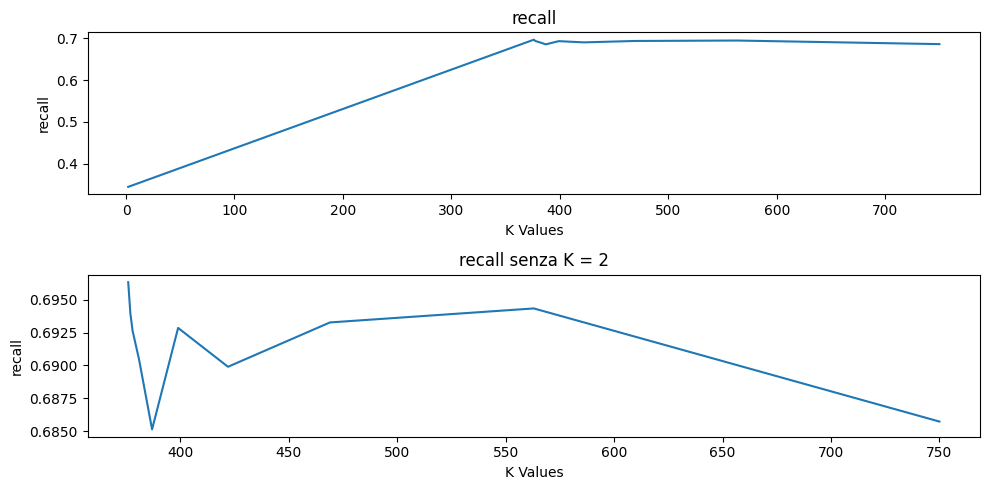

In [11]:
res = sorted(results.items())

x = [k for (k, _) in res]
y = [v for (_, v) in res]
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(x, y);
plt.ylabel(metric)
plt.title(metric)
plt.xlabel("K Values")
plt.subplot(2, 1, 2)
plt.title(metric + " senza K = 2")
plt.xlabel("K Values")
plt.ylabel(metric)
plt.plot(x[1:], y[1:]);
plt.tight_layout()

Eseguiamo ora KNN con il valore "ottimale" di K trovato.

In [12]:
knn = KNeighborsClassifier(n_neighbors=bestK)
knn.fit(cuTrainingX, cuTrainingY)

predictedTrain = knn.predict(cuTrainingX)
predictedTest = knn.predict(cuTestX)

predictedTrain = convertToNumpy(predictedTrain)
predictedTest = convertToNumpy(predictedTest)

metricsTrain = getMetrics(getConfusionMatrix(cuTrainY, predictedTrain))
metricsTest = getMetrics(getConfusionMatrix(cuTestY, predictedTest))

print("\nKNN on Training Set: \t\t\tKNN on Test Set: " )
printAll(metricsTrain, metricsTest)

bestRes["KNN"] = metricsTest


KNN on Training Set: 			KNN on Test Set: 
Accuracy: 	 0.6444078719345988 	Accuracy: 	 0.6437622845796243
Precision: 	 0.6303692600949828 	Precision: 	 0.6290873300363318
Recall: 	 0.6938979555236728 	Recall: 	 0.6963188121208861
F1: 		 0.6606097857682506 	F1: 		 0.6609979061334967


### 6.6 Support Vector Machine (SVM)
    
SVM - Support Vector Machine è un modello discriminativo capace di eseguire classificazione binaria di dati linermente separabili e non. Il modello esegue la classificazione cercando l'**iperpiano separatore** che divide i dati, in particolare si ricerca l'iperpiano separatore che massimizza la sua distanza rispetto ai due **iperpiani di supporto** ovvero i due iperpiani corrispondenti ai punti al margine delle due classi.

La potenzialità di SVM è data dalla possibilità di utilizzare kernel diversi per modellare la separazione dei dati.

#### 6.6.1 SVM Lineare

SVM lineare utilizza un kernel lineare, ovvero un singolo iperpiano separatore. Tale kernel è molto semplice e veloce da calcolare, ma è limitato in quanto non è in grado di separare dati non linearimente separabili.

In [9]:
svm = cuLinearSVC(max_iter=100000)
svm.fit(cuTrainingX, cuTrainingY)

predictionsTrain = svm.predict(cuTrainingX)
predictionsTest = svm.predict(cuTestX)

predictionsTrain = convertToNumpy(predictionsTrain)
predictionsTest = convertToNumpy(predictionsTest)

metricsTrain = getMetrics(getConfusionMatrix(cuTrainY, predictionsTrain))
metricsTest = getMetrics(getConfusionMatrix(cuTestY, predictionsTest))

print("\nLinear SVM (GPU) on Training Set: \tLinear SVM (GPU) on Test Set:")
printAll(metricsTrain, metricsTest)

bestRes["Linear SVM"] = metricsTest


Linear SVM (GPU) on Training Set: 	Linear SVM (GPU) on Test Set:
Accuracy: 	 0.6437236281022967 	Accuracy: 	 0.6429170384184505
Precision: 	 0.6339058190351846 	Precision: 	 0.6321250031401512
Recall: 	 0.6767433209485351 	Recall: 	 0.6776269725857704
F1: 		 0.6546245155248805 	F1: 		 0.6540855980556529


#### 6.6.2 SVM 

Andremo ora a eseguire SVM con vari kernel per valutarne le prestazioni nel nostro particolare problema. Valuteremo le prestazioni dei seguenti kernel:
- **Polinomiale**
- **RBF** (Gaussian Radial Basis Function)
- **Sigmoid** (Tangente iperbolica)

In [9]:
results = dict()
kernels = ["poly", "rbf", "sigmoid"]

for kernel in kernels:
    svm = cuSVC(kernel=kernel, max_iter=10000)
    svm.fit(cuTrainingX, cuTrainingY)

    predictionsTrain = svm.predict(cuTrainingX)
    predictionsTest = svm.predict(cuTestX)
    
    predictionsTrain = convertToNumpy(predictionsTrain)
    predictionsTest = convertToNumpy(predictionsTest)

    metricsTrain = getMetrics(getConfusionMatrix(cuTrainY, predictionsTrain))
    metricsTest = getMetrics(getConfusionMatrix(cuTestY, predictionsTest))
    
    results[kernel] = metricsTest
    
    print("\nSVM con kernel '" + kernel + "' on Training Set: \t\tSVM con kernel '" + kernel + "' on Test Set:")
    printAll(metricsTrain, metricsTest)


SVM con kernel 'poly' on Training Set: 		SVM con kernel 'poly' on Test Set:
Accuracy: 	 0.6335516503469295 	Accuracy: 	 0.6326332101241707
Precision: 	 0.6634730671877082 	Precision: 	 0.6648670199511604
Recall: 	 0.5365227422692445 	Recall: 	 0.5364150538787327
F1: 		 0.5932827208628774 	F1: 		 0.5937734127543414

SVM con kernel 'rbf' on Training Set: 		SVM con kernel 'rbf' on Test Set:
Accuracy: 	 0.640481296217205 	Accuracy: 	 0.6399519685514762
Precision: 	 0.620504806664412 	Precision: 	 0.6216904158627583
Recall: 	 0.7165082884832054 	Recall: 	 0.7168954055647885
F1: 		 0.6650598092603317 	F1: 		 0.6659072517896047

SVM con kernel 'sigmoid' on Training Set: 		SVM con kernel 'sigmoid' on Test Set:
Accuracy: 	 0.4143454179142191 	Accuracy: 	 0.41434503484963336
Precision: 	 0.4117713373527117 	Precision: 	 0.41423261471919987
Recall: 	 0.40988603055045586 	Recall: 	 0.41075162172304724
F1: 		 0.41082652101732586 	F1: 		 0.41248477425520036


In [21]:
bestKernel = max(results, key=lambda x: results[x]["recall"])
bestRes["SVM " + bestKernel] = results[bestKernel]

### 6.7 Logistic Regression

La regressione logistica permette la classificazione binaria eseguendo comunque la regressione con i dati. Il modello sfrutta la funzione **logistic** che esegue in principio un mapping della distribuzione delle label nel campo dei Reali, esegue la regressione e rimappa poi il valore predetto nel range [0, 1]. 

In [24]:
lr = LogisticRegression(max_iter=100000)
lr.fit(trainingX, trainingY)

predictionsTrain = lr.predict(trainingX)
predictionsTest = lr.predict(testX)

metricsTest = getMetrics(getConfusionMatrix(testY, predictionsTest))
metricsTrain = getMetrics(getConfusionMatrix(trainingY, predictionsTrain))

print("\nLogistic Regression on Training Set: \tLogistic Regression on Test Set:")
printAll(metricsTrain, metricsTest)

bestRes["Logistic Regression"] = metricsTest


Logistic Regression on Training Set: 	Logistic Regression on Test Set:
Accuracy: 	 0.6437407202017853 	Accuracy: 	 0.6436841752196955
Precision: 	 0.6357210299333963 	Precision: 	 0.6353215415551314
Recall: 	 0.6698454809450399 	Recall: 	 0.6680943337777957
F1: 		 0.6523372888235217 	F1: 		 0.6512959218507915


In [25]:
with open("bests.json", "a") as f:
    json.dump({"Logistic\nRegression" : metricsTest}, f)

---

## 7. Conclusioni

Creiamo ora un grafico che riassuma le prestazioni dei vari modelli utilizzati.

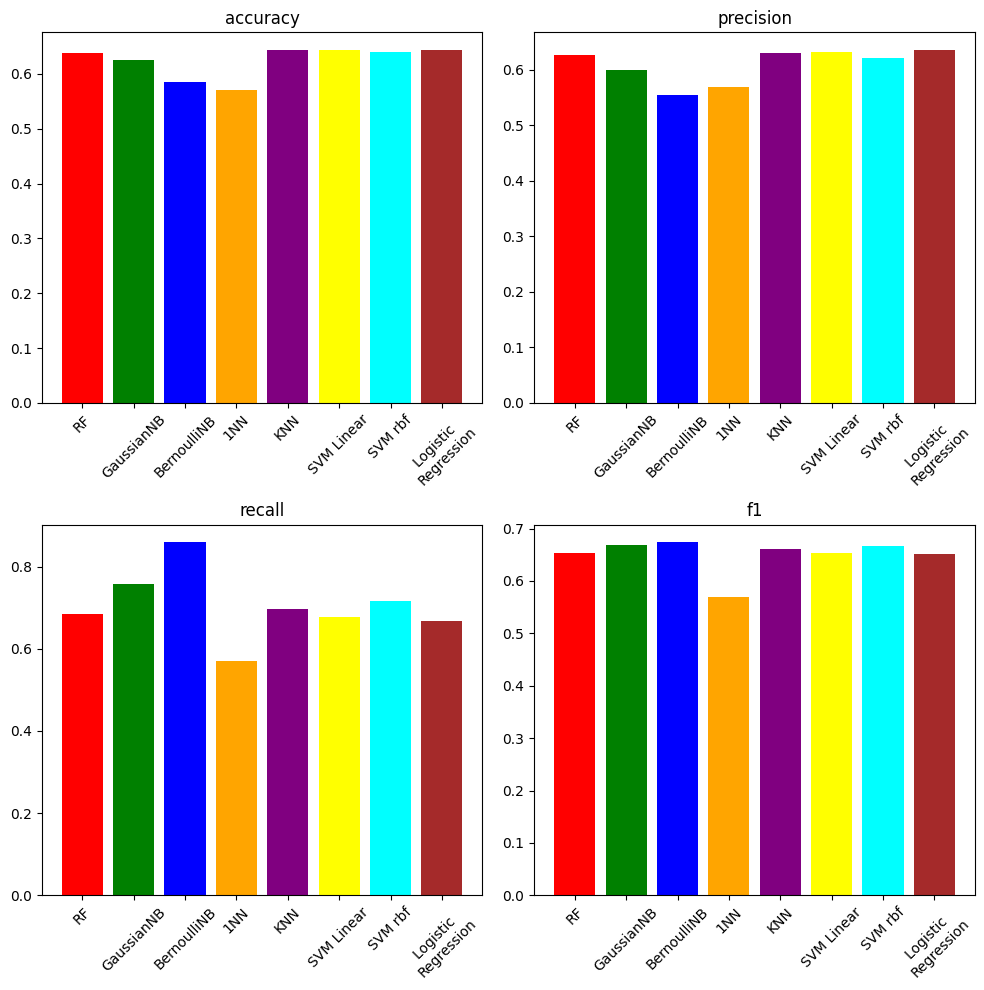

In [56]:
with open("bests.json", "r") as f:
    bests = json.load(f)
    
plt.figure(figsize=(10, 10))
for i, j in np.ndindex(2, 2):
    plt.subplot(2, 2, i * 2 + j + 1)
    plt.title(list(bests[list(bests.keys())[i]].keys())[i * 2 + j])
    plt.bar(list(bests.keys()),
            [bests[x][list(bests[list(bests.keys())[0]])[i * 2 + j]] for x in list(bests.keys())],
            color = ["red", "green", "blue", "orange", "purple", "yellow", "cyan", "brown"])
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Possiamo notare quindi che, a prescindere dalla metrica che decidiamo di massimizzare, nessuno tra i modelli in esame riesce a raggiungere prestazioni ottimali. Questo perchè, anche in base agli studi effettuati sul comportamento del covid-19, non esiste una correlazione **certa** tra le patologie pregresse e la sintomatologia della malattia: è quindi difficile classificare con certezza un paziente.

Se ci poniamo invece il solo obiettivo di massimizzare la recall allora possiamo notare che **Bernoulli Naive Bayes** è il modello con prestazioni migliori, seguito da **Gaussian Naive Bayes** e **SVM con kernel rbf** (che sfrutta comunque la dsitribuzione gaussiana per modellare i dati).


---